### Setup Enviornment

In [1]:
# Install Magenta

!rm -r /content/gansynth &>/dev/null
!mkdir /content/gansynth
!mkdir /content/gansynth/midi
!mkdir /content/gansynth/samples
!gsutil -q -m cp gs://magentadata/models/gansynth/acoustic_only.zip /content/gansynth/
!unzip -o /content/gansynth/acoustic_only.zip -d /content/gansynth &>/dev/null

# Get default MIDI (Bach Prelude)
!curl -o /content/gansynth/midi/bach.mid http://www.jsbach.net/midi/cs1-1pre.mid
MIDI_SONG_DEFAULT = '/content/gansynth/midi/bach.mid'
!curl -o /content/gansynth/midi/riff-default.mid http://storage.googleapis.com/magentadata/papers/gansynth/midi/arp.mid
MIDI_RIFF_DEFAULT = '/content/gansynth/midi/riff-default.mid'

!pip install -q -U magenta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4922  100  4922    0     0   8836      0 --:--:-- --:--:-- --:--:--  8820
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1083  100  1083    0     0   5181      0 --:--:-- --:--:-- --:--:--  5181
     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 5.6MB 15.4MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 358kB 40.8MB/s 
     |████████████████████████████████| 204kB 42.9MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 256kB 39.5MB/s 
     |████████████████████████████████| 8.3MB 27.8MB/s 
     |████████████████████████████████| 2.3MB 43.4MB/s 
     |████████████████████

In [2]:
import os
import librosa
import note_seq

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from google.colab import files
from magenta.models.gansynth.lib import util
from magenta.models.nsynth.utils import load_audio
from note_seq.notebook_utils import colab_play as play
from magenta.models.gansynth.lib import flags as lib_flags
from magenta.models.gansynth.lib import model as lib_model
from magenta.models.gansynth.lib import generate_util as gu

In [3]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
download = files.download

def upload():
  '''Upload a .wav file.'''
  filemap = files.upload()
  file_list = []
  for key, value in filemap.iteritems():
    fname = os.path.join('/content/gansynth/midi', key)
    with open(fname, 'w') as f:
      f.write(value)
      print('Writing {}'.format(fname))
    file_list.append(fname)
  return file_list

In [5]:
# GLOBAL PARAMS

CKPT_DIR = '/content/gansynth/acoustic_only'
output_dir = '/content/gansynth/samples'
BATCH_SIZE = 16
SR = 16000

In [6]:
OUTPUT_DIR = util.expand_path(output_dir)
if not tf.gfile.Exists(OUTPUT_DIR):
  tf.gfile.MakeDirs(OUTPUT_DIR)

In [7]:
tf.reset_default_graph()
flags = lib_flags.Flags({'batch_size_schedule': [BATCH_SIZE]})
model = lib_model.Model.load_from_path(CKPT_DIR, flags)

	adam_beta1: 0.0
	adam_beta2: 0.99
	audio_length: 64000
	batch_size_schedule: [8]
	d_fn: specgram
	data_normalizer: specgrams_prespecified_normalizer
	data_type: mel
	dataset_name: nsynth_tfrecord
	debug_hook: False
	discriminator_ac_loss_weight: 10.0
	discriminator_learning_rate: 0.0008
	fake_batch_size: 61
	fmap_base: 4096
	fmap_decay: 1.0
	fmap_max: 256
	g_fn: specgram
	gan:
	gen_gl_consistency_loss_weight: 0.0
	generator_ac_loss_weight: 10.0
	generator_learning_rate: 0.0008
	gradient_penalty_target: 1.0
	gradient_penalty_weight: 10.0
	kernel_size: 3
	latent_vector_size: 256
	mag_normalizer_a: 0.0661371661726
	mag_normalizer_b: 0.113718730221
	master: 
	normalizer_margin: 0.8
	normalizer_num_examples: 1000
	num_resolutions: 7
	p_normalizer_a: 0.8
	p_normalizer_b: 0.0
	ps_tasks: 0
	real_score_penalty_weight: 0.001
	sample_rate: 16000
	save_summaries_num_images: 10000
	scale_base: 2
	scale_mode: ALL
	simple_arch: False
	stable_stage_num_images: 800000
	start_height: 2
	start_width: 16

### Helper Functions

In [8]:
def load_midi(midi_path, min_pitch = 36, max_pitch = 84):
  """Load midi as a notesequence."""
  midi_path = util.expand_path(midi_path)
  ns = note_seq.midi_file_to_sequence_proto(midi_path)
  pitches = np.array([n.pitch for n in ns.notes])
  velocities = np.array([n.velocity for n in ns.notes])
  start_times = np.array([n.start_time for n in ns.notes])
  end_times = np.array([n.end_time for n in ns.notes])
  valid = np.logical_and(pitches >= min_pitch, pitches <= max_pitch)
  notes = {'pitches': pitches[valid],
           'velocities': velocities[valid],
           'start_times': start_times[valid],
           'end_times': end_times[valid]}
  return ns, notes

def get_envelope(t_note_length, t_attack = 0.010, t_release = 0.3, sr = 16000):
  """Create an attack sustain release amplitude envelope."""
  t_note_length = min(t_note_length, 3.0)
  i_attack = int(sr * t_attack)
  i_sustain = int(sr * t_note_length)
  i_release = int(sr * t_release)
  i_tot = i_sustain + i_release  # attack envelope doesn't add to sound length
  envelope = np.ones(i_tot)
  # Linear attack
  envelope[:i_attack] = np.linspace(0.0, 1.0, i_attack)
  # Linear release
  envelope[i_sustain:i_tot] = np.linspace(1.0, 0.0, i_release)
  return envelope

def combine_notes(audio_notes, start_times, end_times, velocities, sr = 16000):
  """Combine audio from multiple notes into a single audio clip.

  Args:
    audio_notes: Array of audio [n_notes, audio_samples].
    start_times: Array of note starts in seconds [n_notes].
    end_times: Array of note ends in seconds [n_notes].
    sr: Integer, sample rate.

  Returns:
    audio_clip: Array of combined audio clip [audio_samples]
  """
  n_notes = len(audio_notes)
  clip_length = end_times.max() + 3.0
  audio_clip = np.zeros(int(clip_length) * sr)

  for t_start, t_end, vel, i in zip(start_times, end_times, velocities, range(n_notes)):
    # Generate an amplitude envelope
    t_note_length = t_end - t_start
    envelope = get_envelope(t_note_length)
    length = len(envelope)
    audio_note = audio_notes[i, :length] * envelope
    # Normalize
    audio_note /= audio_note.max()
    audio_note *= (vel / 127.0)
    # Add to clip buffer
    clip_start = int(t_start * sr)
    clip_end = clip_start + length
    audio_clip[clip_start:clip_end] += audio_note

  # Normalize
  audio_clip /= audio_clip.max()
  audio_clip /= 2.0
  return audio_clip

# Plotting tools
def specplot(audio_clip):
  p_min = np.min(36)
  p_max = np.max(84)
  f_min = librosa.midi_to_hz(p_min)
  f_max = 2 * librosa.midi_to_hz(p_max)
  octaves = int(np.ceil(np.log2(f_max) - np.log2(f_min)))
  bins_per_octave = 36
  n_bins = int(bins_per_octave * octaves)
  C = librosa.cqt(audio_clip, sr = SR, hop_length = 2048, fmin = f_min, n_bins = n_bins, bins_per_octave = bins_per_octave)
  power = 10 * np.log10(np.abs(C)**2 + 1e-6)
  plt.matshow(power[::-1, 2:-2], aspect = 'auto', cmap = plt.cm.magma)
  plt.yticks([])
  plt.xticks([])

### Random Interpolation

In [9]:
midi_file = "Bach Prelude (Default)"

midi_path = MIDI_SONG_DEFAULT
if midi_file == "Upload your own":
  try:
    file_list = upload()
    midi_path = file_list[0]
  except Exception as e:
    print('Upload Cancelled')

ns, notes = load_midi(midi_path)
print('Loaded {}'.format(midi_path))
note_seq.plot_sequence(ns)

Loaded /content/gansynth/midi/bach.mid


### Display a Constant-Q spectrogram

Generating 656 samples...
generate_samples: generated 656 samples in 25.78747797012329s

Audio:


CQT Spectrogram:


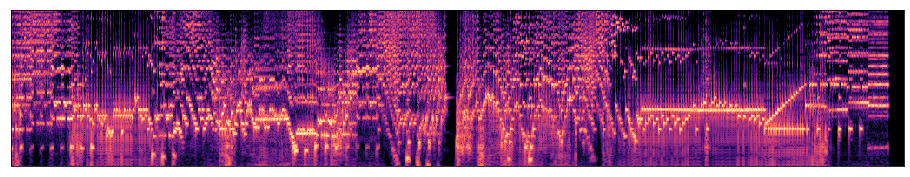

In [10]:
seconds_per_instrument = 5 

# Distribute latent vectors linearly in time
z_instruments, t_instruments = gu.get_random_instruments(
    model, notes['end_times'][-1], secs_per_instrument = seconds_per_instrument)

# Get latent vectors for each note
z_notes = gu.get_z_notes(notes['start_times'], z_instruments, t_instruments)

# Generate audio for each note
print('Generating {} samples...'.format(len(z_notes)))
audio_notes = model.generate_samples_from_z(z_notes, notes['pitches'])

# Make a single audio clip
audio_clip = combine_notes(audio_notes,
                           notes['start_times'],
                           notes['end_times'],
                           notes['velocities'])

# Play the audio
print('\nAudio:')
play(audio_clip, sample_rate = SR)
print('CQT Spectrogram:')
specplot(audio_clip)

### Choose Interpolations

In [11]:
midi_file = "Arpeggio (Default)" 

midi_path = MIDI_RIFF_DEFAULT
if midi_file == "Upload your own":
  try:
    file_list = upload()
    midi_path = file_list[0]
    ns, notes_2 = load_midi(midi_path)
  except Exception as e:
    print('Upload Cancelled')
else:
  # Load Default, but slow it down 30%
  ns, notes_2 = load_midi(midi_path)
  notes_2['start_times'] *= 1.3
  notes_2['end_times'] *= 1.3


print('Loaded {}'.format(midi_path))
note_seq.plot_sequence(ns)

Loaded /content/gansynth/midi/riff-default.mid


In [12]:
number_of_random_instruments = 10 
pitch_preview = 60
n_preview = number_of_random_instruments

pitches_preview = [pitch_preview] * n_preview
z_preview = model.generate_z(n_preview)

audio_notes = model.generate_samples_from_z(z_preview, pitches_preview)
for i, audio_note in enumerate(audio_notes):
  print("Instrument: {}".format(i))
  play(audio_note, sample_rate=16000)

generate_samples: generated 10 samples in 0.5122840404510498s
Instrument: 0


Instrument: 1


Instrument: 2


Instrument: 3


Instrument: 4


Instrument: 5


Instrument: 6


Instrument: 7


Instrument: 8


Instrument: 9
